## Image processing

Objeto para crear objeto data loader 

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os

# Data processing

In [4]:
data_dir = './db'
# os.makedirs(os.path.join(data_dir, 'class1'), exist_ok=True)

## Image skeletonization

In [5]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from skimage.util import invert
import skimage as ski
from skimage.filters import threshold_otsu

In [3]:
import os

In [9]:
files = os.listdir(data_dir+'/unet_1/img')

In [54]:
files[0]

'nj_124_2_LCA_RAO.png'

In [23]:
def readImages(dir):
    img_file = os.listdir(data_dir+'/unet_1/img')
    label_file = os.listdir(data_dir+'/unet_1/label')
    list = [ [], [] ]
    for img, label in zip(img_file, label_file):
        list[0].append(ski.io.imread(dir+'/unet_1/img/'+img))
        list[1].append(ski.io.imread(dir+'/unet_1/label/'+label))
    return list[0], list[1]

In [27]:
img, label = readImages(data_dir)

In [59]:
gray_image = ski.color.rgb2gray(label[0])

In [60]:
gray_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
gray_image.shape

(512, 512)

In [46]:
skeleton = skeletonize(gray_image)

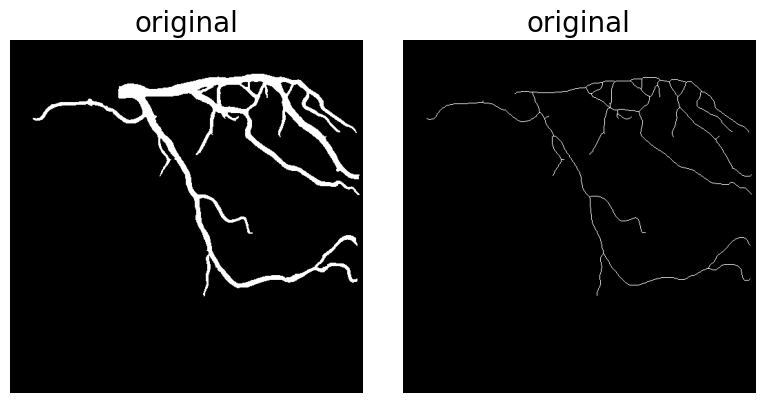

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(label[0], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('original', fontsize=20)

fig.tight_layout()
plt.show()n

## DataLoader

In [49]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [69]:
class UnetDataset(Dataset):
    
    def __init__(self, dir, img, label, transform=None, target_transform=None):
        super().__init__()
        self.dir = dir
        self.img = img
        self.label = label
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        
        img = read_image(self.dir+'/img/'+self.img[idx])
        
        label = ski.io.imread(self.dir+'/img/'+self.label[idx])
        label =  ski.color.rgb2gray(label)
        label = skeletonize(label)
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        
        return img, label
        
        

## Model Architecture

In [ ]:
class DoubleConv(nn.Module):
    def __init__ (self, in_channels, out_channels):
        super().__init__
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True,
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
        

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 2, features = [64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride = 2))
            self.ups.append(DoubleConv(feature*2, feature))
            
        
        self.bottom = DoubleConv(features[-1], features[-1]*2)
        self.last = nn.Conv2d(features[0], out_channels, 1

    def forward(self, x):
            sc = []
            for down in self.downs:
                x = down(x)
                sc.append(x)
                x = self.pool(x)
                
            x =self.bottom(x)

            for up in self.ups:
                
            
        

## Loss Function

- Binary cross entropy loss function

In [63]:
def ce(y, y_i):
    ep = 1e-8
    part1 = y_i * np.log(y+ep)
    part2 = (1 - y_i)*np.log(1-y+ep)
    return np.mean(-(part1+part2))

In [64]:
y = np.linspace(0,1, 10)
y_i = np.zeros(10)
y_i2 = np.ones(10)

r1 = ce(y, y_i)
r2 = ce(y, y_i2)

In [68]:
x = np.linspace(0,1,9).reshape(3,3)

In [69]:
x

array([[0.   , 0.125, 0.25 ],
       [0.375, 0.5  , 0.625],
       [0.75 , 0.875, 1.   ]])

In [72]:
y_1 = np.ones(9).reshape(3,3)

In [73]:
y_0 = np.zeros(9).reshape(3,3)

In [74]:
ce(x, y_1)

2.7168455508019154

In [65]:
r1

2.5393874205289735

In [66]:
r2

2.539387420528974

In [52]:
r1

array([       nan, 0.11778304, 0.25131443, 0.40546511, 0.58778666,
       0.81093022, 1.09861229, 1.5040774 , 2.19722458,        inf])

In [53]:
r2

array([       inf, 2.19722458, 1.5040774 , 1.09861229, 0.81093022,
       0.58778666, 0.40546511, 0.25131443, 0.11778304,        nan])

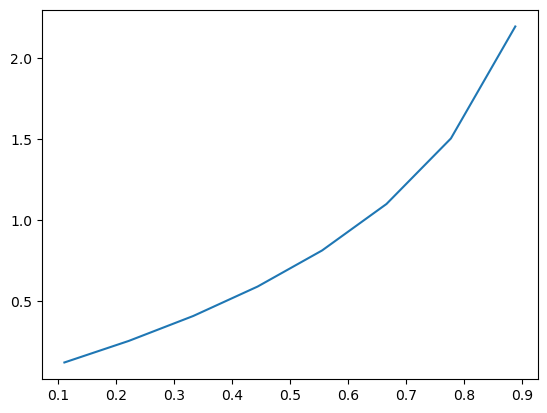

In [54]:
plt.plot(y, r1)

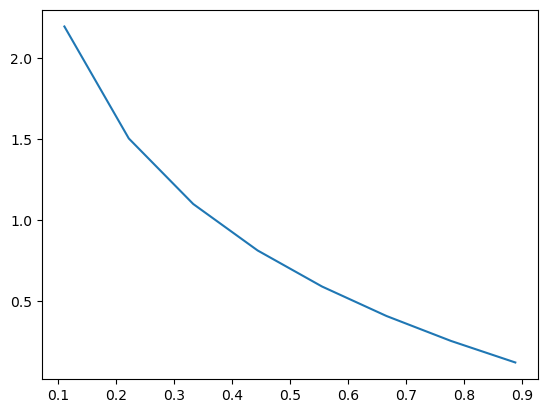

In [55]:
plt.plot(y, r2)

In [ ]:
loss = nn.BCELoss()